In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from math import floor

from matplotlib import pyplot as plt
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
if os.path.exists("./tensor_y.npy"):
    os.remove("./tensor_y.npy")
if os.path.exists("./tensor_x.npy"):
    os.remove("./tensor_x.npy")
if os.path.exists("./val_tensor_x.npy"):
    os.remove("./val_tensor_x.npy")
if os.path.exists("./val_tensor_y.npy"):
    os.remove("./val_tensor_y.npy")

In [46]:
epochs = 20
batch_size = 8
lr = 1e-4

alpha = 0.1

resize_height = 256
resize_width = 256

ratio = 4
train_val_split_perc = 0.7
val_test_split_perc = 0.5

In [28]:
class Generator(keras.utils.Sequence):
    def __init__(self, x: list, y: list):
        self.x = x
        self.y = y
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        
        return x, y
    
    def __call__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)
            
            if i == self.__len__()-1:
                self.on_epoch_end()

In [29]:
def preprocessing(path, ratio, resize_height, resize_width):
    y = tf.keras.utils.load_img(path)
    y = tf.keras.utils.img_to_array(y)
    y = tf.image.resize(y,[resize_height, resize_width],'bicubic',antialias=True,)
    height, width, _ = y.shape
    x = tf.image.resize(y,[height // ratio, width // ratio],'bicubic',antialias=True,)
    x = x / 255.0
    y = y / 255.0
    return x, y

In [30]:
img_paths = []
val_img_paths = []
for dirname, _, filenames in os.walk('../input/div2k-dataset/DIV2K_train_HR'):
    for filename in filenames:
        img_paths.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('../input/div2k-dataset/DIV2K_valid_HR'):
    for filename in filenames:
        img_paths.append(os.path.join(dirname, filename))
        
print('Dataset dimension: ', len(img_paths))

val_img_paths = img_paths[floor(len(img_paths) * train_val_split_perc):]
img_paths = img_paths[:floor(len(img_paths) * train_val_split_perc)]
print('Training: ', len(img_paths))

Dataset dimension:  900
Training:  630


In [31]:
if not (os.path.exists('./tensor_x.npy')) or not (os.path.exists('./tensor_y.npy')):

    img_lr = []
    img_hr = []

    for i in tqdm(range(len(img_paths))):
        x, y = preprocessing(img_paths[i], ratio, resize_height, resize_width)
        img_lr.append(x)
        img_hr.append(y)
    
    tensor_x = tf.convert_to_tensor(img_lr).numpy()
    tensor_y = tf.convert_to_tensor(img_hr).numpy()
    tensor_x.shape

    np.save('./tensor_x.npy', tensor_x)
    np.save('./tensor_y.npy', tensor_y)
    img_lr = tensor_x
    img_hr = tensor_y
else:
    img_lr = np.load('./tensor_x.npy')
    img_hr = np.load('./tensor_y.npy')


In [32]:
if not (os.path.exists('./val_tensor_x.npy')) or not (os.path.exists('./val_tensor_y.npy')):

    val_img_lr = []
    val_img_hr = []

    for i in tqdm(range(len(val_img_paths))):
        x, y = preprocessing(val_img_paths[i], ratio, resize_height * 2, resize_width * 2)
        val_img_lr.append(x)
        val_img_hr.append(y)
    
    val_tensor_x = tf.convert_to_tensor(val_img_lr).numpy()
    val_tensor_y = tf.convert_to_tensor(val_img_hr).numpy()

    np.save('./val_tensor_x.npy', val_tensor_x)
    np.save('./val_tensor_y.npy', val_tensor_y)
    val_img_lr = tensor_x
    val_img_hr = tensor_y
else:
    val_img_lr = np.load('./val_tensor_x.npy')
    val_img_hr = np.load('./val_tensor_y.npy')

In [33]:
train_generator = Generator(img_lr, img_hr)
val_generator = Generator(val_img_lr[:floor(val_img_lr.shape[0] * val_test_split_perc)], val_img_hr[:floor(val_img_lr.shape[0] * val_test_split_perc)])
test_generator = Generator(val_img_lr[floor(val_img_lr.shape[0] * val_test_split_perc):], val_img_hr[floor(val_img_lr.shape[0] * val_test_split_perc):])

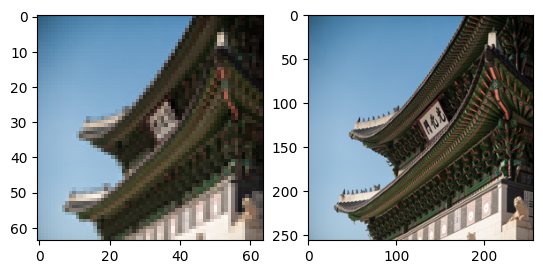

In [35]:
x, y = train_generator[44]

plt.figure()
plt.subplot(1,2,1)
plt.imshow(x)
plt.subplot(1,2,2)
plt.imshow(y)

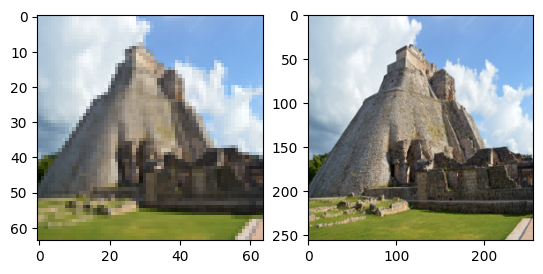

In [36]:
x, y = train_generator[45]

plt.figure()
plt.subplot(1,2,1)
plt.imshow(x)
plt.subplot(1,2,2)
plt.imshow(y)

In [37]:
train_dataset = tf.data.Dataset.from_generator(train_generator,
                                                   output_shapes=([None, None, 3], [None, None, 3]),
                                                   output_types=(x.dtype, y.dtype)).batch(batch_size)

train_dataset = train_dataset.prefetch(4)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(len(train_generator) + 1, reshuffle_each_iteration=True)


In [38]:
val_dataset = tf.data.Dataset.from_generator(val_generator,
                                                   output_shapes=([None, None, 3], [None, None, 3]),
                                                   output_types=(x.dtype, y.dtype)).batch(batch_size)
val_dataset = val_dataset.prefetch(4)
val_dataset = val_dataset.cache()

In [39]:
test_dataset = tf.data.Dataset.from_generator(test_generator,
                                                   output_shapes=([None, None, 3], [None, None, 3]),
                                                   output_types=(x.dtype, y.dtype)).batch(batch_size)
test_dataset = test_dataset.prefetch(4)
test_dataset = test_dataset.cache()

In [40]:
@tf.function
def MeanGradientError(targets, outputs):
    filter_x = tf.tile(tf.expand_dims(tf.constant([[-1, -2, -2], [0, 0, 0], [1, 2, 1]], dtype = outputs.dtype), axis = -1), [1, 1, outputs.shape[-1]])
    filter_x = tf.tile(tf.expand_dims(filter_x, axis = -1), [1, 1, 1, outputs.shape[-1]])
    filter_y = tf.tile(tf.expand_dims(tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype = outputs.dtype), axis = -1), [1, 1, targets.shape[-1]])
    filter_y = tf.tile(tf.expand_dims(filter_y, axis = -1), [1, 1, 1, targets.shape[-1]])
    
     # output gradient
    output_gradient_x = tf.math.square(tf.nn.conv2d(outputs, filter_x, strides = 1, padding = 'SAME'))
    output_gradient_y = tf.math.square(tf.nn.conv2d(outputs, filter_y, strides = 1, padding = 'SAME'))

    #target gradient
    target_gradient_x = tf.math.square(tf.nn.conv2d(targets, filter_x, strides = 1, padding = 'SAME'))
    target_gradient_y = tf.math.square(tf.nn.conv2d(targets, filter_y, strides = 1, padding = 'SAME'))
    
     # square
    output_gradients = tf.math.add(output_gradient_x, output_gradient_y)
    target_gradients = tf.math.add(target_gradient_x, target_gradient_y)

    # compute mean gradient error
    mge = tf.keras.metrics.mean_absolute_error(output_gradients, target_gradients)

    return mge


In [41]:
@tf.function
def overall_loss_func(y_true, y_pred):
    mae_loss = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mge_loss = MeanGradientError(y_true, y_pred)
    return mae_loss + alpha * mge_loss

In [47]:
def SR_model(upscale_factor=4, channels=3):
    conv_args = {
        "activation": "relu",
        "padding": "same",
    }
    inputs = layers.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(16, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

In [48]:
net = SR_model()
net.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d_8 (Conv2D)           (None, None, None, 64)    4864      
                                                                 
 conv2d_9 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_10 (Conv2D)          (None, None, None, 16)    4624      
                                                                 
 conv2d_11 (Conv2D)          (None, None, None, 48)    6960      
                                                                 
 tf.nn.depth_to_space_2 (TF  (None, None, None, 3)     0         
 OpLambda)                                                       
                                                           

In [49]:
net.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss=overall_loss_func, metrics=['mae', MeanGradientError])

In [54]:
history = net.fit(
        x = train_dataset,
        epochs = epochs,
        verbose = 1,
        validation_data = val_dataset
)

Epoch 1/20
102/102 [==============================] - 1s 12ms/step - loss: 0.4387 - mae: 0.0823 - MeanGradientError: 3.5649 - val_loss: 0.3721 - val_mae: 0.0737 - val_MeanGradientError: 2.9842
Epoch 2/20
102/102 [==============================] - 1s 11ms/step - loss: 0.4365 - mae: 0.0816 - MeanGradientError: 3.5487 - val_loss: 0.3684 - val_mae: 0.0729 - val_MeanGradientError: 2.9550
Epoch 3/20
102/102 [==============================] - 1s 11ms/step - loss: 0.4350 - mae: 0.0812 - MeanGradientError: 3.5381 - val_loss: 0.3665 - val_mae: 0.0719 - val_MeanGradientError: 2.9456
Epoch 4/20
102/102 [==============================] - 1s 11ms/step - loss: 0.4335 - mae: 0.0806 - MeanGradientError: 3.5286 - val_loss: 0.3675 - val_mae: 0.0715 - val_MeanGradientError: 2.9596
Epoch 5/20
102/102 [==============================] - 1s 11ms/step - loss: 0.4332 - mae: 0.0801 - MeanGradientError: 3.5307 - val_loss: 0.3673 - val_mae: 0.0717 - val_MeanGradientError: 2.9566
Epoch 6/20
102/102 [===============

In [56]:
outputs = net.predict(test_dataset)

6/6 [==============================] - 0s 11ms/step


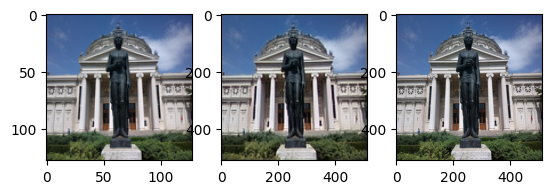

In [60]:
x, y = test_generator[11]
plt.figure()
plt.subplot(1,3,1)
plt.imshow(x)
plt.subplot(1,3,2)
plt.imshow(outputs[11])
plt.subplot(1,3,3)
plt.imshow(y)